In [1]:
import json
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN, GRU, LSTM
from keras.layers.core import Dense, Dropout
from keras.layers.wrappers import TimeDistributed
from keras.layers import Convolution1D, MaxPooling1D
from keras.utils import np_utils
import itertools
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sys, os
import traceback
from itertools import chain
import numpy as np
import pandas as pd

import progressbar

import tensorflow as tf
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
def read_data(rootdir):
    data_list = []
    for subdir, dirs, files in os.walk(rootdir):
        for fname in files:
            #print os.path.join(subdir, file)
            filepath = subdir + os.sep + fname
            with open(filepath) as f:
                for line1,line2 in itertools.izip_longest(*[f]*2):
                    try:
                        text = ast.literal_eval(line1)
                        label = ast.literal_eval(line2)
                        n_labels = set(label)
                        if len(text) > 3 and len(n_labels) > 1:
                            sentence = zip(text, label)
                            sentence = [item for item in sentence if item[0].strip() != '']
                            data_list.append(sentence)
                    except:
                        pass
            f.close()
    return data_list

In [4]:
data_list = read_data('../data/input/GO/')

print data_list[0]

# data_list = data_list[:3000]

# words = list(chain.from_iterable(data_list))
# print words

words = list(set(y[0] for x in data_list for y in x))
words.append("ENDPAD")
n_words = len(words); n_words

tags = list(set(y[1] for x in data_list for y in x))
n_tags = len(tags); n_tags

[('Rod', 'NA'), ('and', 'NA'), ('cone', 'NA'), ('photoreceptors', 'NA'), ('subserve', 'NA'), ('vision', 'NA'), ('under', 'NA'), ('dim', 'NA'), ('and', 'NA'), ('bright', 'NA'), ('light', 'NA'), ('conditions', 'NA'), ('respectively', 'NA'), ('The', 'NA'), ('differences', 'NA'), ('in', 'NA'), ('their', 'NA'), ('function', 'NA'), ('are', 'NA'), ('thought', 'NA'), ('to', 'NA'), ('stem', 'NA'), ('from', 'NA'), ('their', 'NA'), ('different', 'NA'), ('gene', 'NA'), ('expression', 'NA'), ('patterns', 'NA'), ('morphologies', 'NA'), ('and', 'NA'), ('synaptic', 'GO:0045202'), ('connectivities', 'NA'), ('In', 'NA'), ('this', 'NA'), ('study', 'NA'), ('we', 'NA'), ('have', 'NA'), ('examined', 'NA'), ('the', 'NA'), ('photoreceptor', 'NA'), ('cells', 'GO:0005623'), ('of', 'NA'), ('the', 'NA'), ('retinal', 'NA'), ('degeneration', 'NA'), ('7', 'NA'), ('rd7', 'NA'), ('mutant', 'NA'), ('mouse', 'NA'), ('a', 'NA'), ('model', 'NA'), ('for', 'NA'), ('the', 'NA'), ('human', 'NA'), ('enhanced', 'NA'), ('Scone',

104

In [5]:
# from sklearn.preprocessing import LabelEncoder

# le = LabelEncoder()
# le.fit(list(y[1] for x in data_list for y in x))

# labels2idx = dict(zip(le.classes_, le.transform(le.classes_)))

# idx2la = {labels2idx[k]:k for k in labels2idx}

In [13]:
max_len = 75
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags, 1)}
tag2idx['0'] = 0
n_tags += 1

idx2tag = {v: k for k, v in tag2idx.iteritems()}

print word2idx['Hybrid']
print tag2idx["NA"]

893
69


In [14]:
print tag2idx

{'GO:0005783': 1, 'GO:0035102': 2, 'GO:0030425': 3, 'GO:0030424': 4, 'GO:0030056': 5, 'GO:0030054': 6, 'GO:0016028': 7, 'GO:0031982': 8, 'GO:0005773': 9, 'GO:0005835': 10, 'GO:0016021': 11, 'GO:0016020': 12, 'GO:0005777': 13, 'GO:0005776': 14, 'GO:0005833': 15, '0': 0, 'GO:0016459': 16, 'GO:0005675': 17, 'GO:0032391': 18, 'GO:0005792': 19, 'GO:0031965': 20, 'GO:0000792': 21, 'GO:0000791': 22, 'GO:0000795': 23, 'GO:0000502': 24, 'GO:0042995': 25, 'GO:0001750': 26, 'GO:0042611': 27, 'GO:0045251': 28, 'GO:0005829': 29, 'GO:0010369': 30, 'GO:0001917': 31, 'GO:0030849': 32, 'GO:0031240': 33, 'GO:0000785': 34, 'GO:0000786': 83, 'GO:0030286': 36, 'GO:0043226': 37, 'GO:0005856': 38, 'GO:0042555': 39, 'GO:0043679': 40, 'GO:0005712': 41, 'GO:0005654': 42, 'GO:0005656': 43, 'GO:0005657': 44, 'GO:0048471': 45, 'GO:0043025': 46, 'GO:0008305': 47, 'GO:0043256': 48, 'GO:0043204': 49, 'GO:0008091': 50, 'GO:0005840': 51, 'GO:0005643': 52, 'GO:0043209': 53, 'GO:0017086': 54, 'GO:0031012': 55, 'GO:003001

In [15]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in data_list]

In [16]:
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=-1)

In [17]:
y = [[tag2idx[w[1]] for w in s] for s in data_list]

In [18]:
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["NA"])

In [19]:
from keras.utils import to_categorical

y = [to_categorical(i, num_classes=n_tags) for i in y]

In [20]:
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3)

In [21]:
# from sklearn.utils import class_weight
# import numpy as np

# cw = class_weight.compute_class_weight('balanced',
#                                                  np.unique(y_tr),
#                                                  y_tr)

In [22]:
print np.shape(X_tr), np.shape(X_te), np.shape(y_tr), np.shape(y_te)

(1336, 75) (573, 75) (1336, 75, 105) (573, 75, 105)


In [23]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words + 1, output_dim=100,
                  input_length=max_len, mask_zero=True)(input)  # 20-dim embedding
model = Bidirectional(LSTM(units=100, return_sequences=True,
                           recurrent_dropout=0.25))(model)  # variational biLSTM
model = TimeDistributed(Dense(n_tags, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags)  # CRF layer
out = crf(model)  # output

In [24]:
model = Model(input, out)

In [25]:
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

In [26]:
model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 100)           1674700   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 200)           160800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 75, 105)           21105     
_________________________________________________________________
crf_1 (CRF)                  (None, 75, 105)           22365     
Total params: 1,878,970
Trainable params: 1,878,970
Non-trainable params: 0
_________________________________________________________________


In [28]:
history = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=15,
                    validation_data=(X_te, np.array(y_te)), class_weight = 'auto', verbose=1)

Train on 1336 samples, validate on 573 samples
Epoch 1/15
1336/1336 [==============================] - 15s 11ms/step - loss: 0.0297 - viterbi_acc: 0.9931 - val_loss: 0.0509 - val_viterbi_acc: 0.9925
Epoch 2/15
1336/1336 [==============================] - 15s 11ms/step - loss: 0.0276 - viterbi_acc: 0.9935 - val_loss: 0.0471 - val_viterbi_acc: 0.9926
Epoch 3/15
1336/1336 [==============================] - 15s 11ms/step - loss: 0.0250 - viterbi_acc: 0.9942 - val_loss: 0.0615 - val_viterbi_acc: 0.9927
Epoch 4/15
1336/1336 [==============================] - 15s 11ms/step - loss: 0.0234 - viterbi_acc: 0.9947 - val_loss: 0.0448 - val_viterbi_acc: 0.9931
Epoch 5/15
1336/1336 [==============================] - 15s 11ms/step - loss: 0.0213 - viterbi_acc: 0.9950 - val_loss: 0.0440 - val_viterbi_acc: 0.9936
Epoch 6/15
1336/1336 [==============================] - 15s 11ms/step - loss: 0.0192 - viterbi_acc: 0.9955 - val_loss: 0.0449 - val_viterbi_acc: 0.9942
Epoch 7/15
1336/1336 [===================

In [29]:
hist = pd.DataFrame(history.history)

In [30]:
print hist

        loss  val_loss  val_viterbi_acc  viterbi_acc
0   0.029747  0.050866         0.992461     0.993064
1   0.027580  0.047134         0.992600     0.993523
2   0.024999  0.061524         0.992670     0.994172
3   0.023389  0.044797         0.993136     0.994671
4   0.021272  0.044043         0.993554     0.995040
5   0.019152  0.044856         0.994183     0.995519
6   0.017248  0.042678         0.994602     0.995848
7   0.015305  0.043584         0.994695     0.996277
8   0.013414  0.046443         0.994951     0.996717
9   0.011865  0.044029         0.995090     0.997106
10  0.010046  0.047346         0.995369     0.997525
11  0.008445  0.050624         0.995183     0.997984
12  0.007449  0.047757         0.995393     0.998134
13  0.006318  0.051735         0.995439     0.998423
14  0.005555  0.052497         0.995532     0.998673


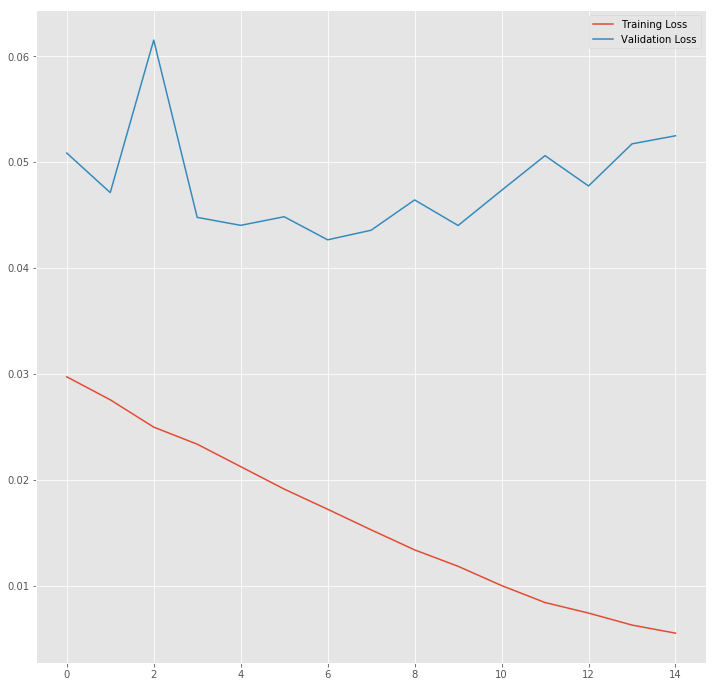

In [31]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["loss"], label='Training Loss')
plt.plot(hist["val_loss"], label='Validation Loss')
plt.legend()
plt.show()

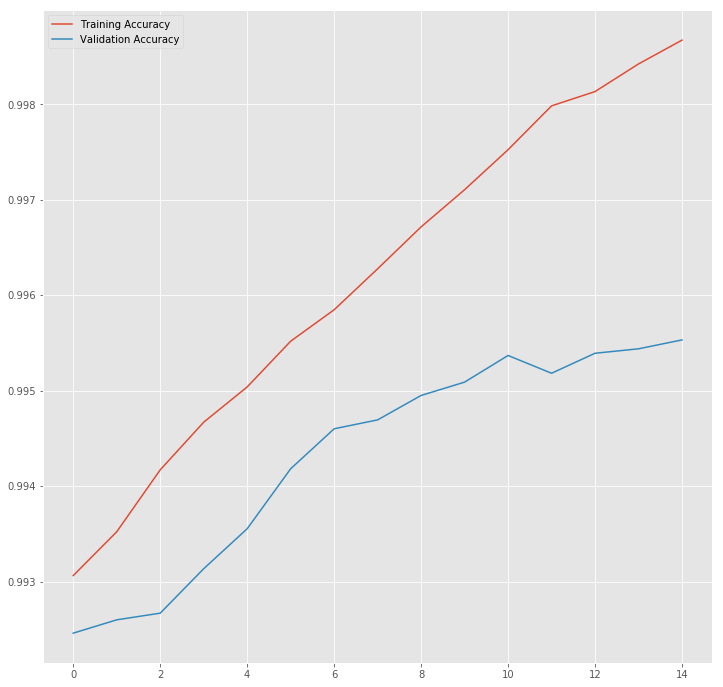

In [32]:
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["viterbi_acc"], label='Training Accuracy')
plt.plot(hist["val_viterbi_acc"], label='Validation Accuracy')
plt.legend()
plt.show()

In [33]:
from sklearn.metrics import classification_report

predicted = model.predict(X_te)

true = []
predicted_val = []
for i in range(len(predicted[:20])):
    p_tmp = np.argmax(predicted[i], axis=-1)
    t_tmp = np.argmax(y_te[i], -1)
    predicted_val.append(p_tmp)
    true.append(t_tmp)

    
p = [list(map(lambda x: idx2tag[x], y)) for y in predicted_val]
t = [list(map(lambda x: idx2tag[x], y)) for y in true]

print predicted_val[2]
print true[2]


print p[2]
print t[2]

report = classification_report(list(itertools.chain.from_iterable(t)), 
                                    list(itertools.chain.from_iterable(p)))
print "\n"
print report

[69 69 69 69 69 69 69 91 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69
 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 91 69 69 69 69 69 69 69
 69 69 69 69 69 69 69 69 91 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69
 69 69 69]
[69 69 69 69 69 69 69 91 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69
 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69 91 69 69 69 69 69 69 69
 69 69 69 69 69 69 69 69 91 69 69 69 69 69 69 69 69 69 69 69 69 69 69 69
 69 69 69]
['NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'GO:0005694', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'GO:0005694', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'GO:0005694', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA']
['NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'GO:0005694', 'NA', 'N

/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [34]:
i = 300
pd = model.predict(np.array([X_te[i]]))
pd = np.argmax(pd, axis=-1)
true = np.argmax(y_te[i], -1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")

for w, t1, pred in zip(X_te[i], true, pd[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-1], tags[t1], tags[pred]))

Word           ||True ||Pred
from           : GO:0005634 GO:0005634
C57BL10        : GO:0005634 GO:0005634
and            : GO:0005634 GO:0005634
C57BL6         : GO:0005634 GO:0005634
strains        : GO:0005634 GO:0005634
have           : GO:0005634 GO:0005634
been           : GO:0005634 GO:0005634
mapped         : GO:0005634 GO:0005634
to             : GO:0005634 GO:0005634
a              : GO:0005634 GO:0005634
portion        : GO:0005634 GO:0005634
of             : GO:0005634 GO:0005634
Chromosome     : GO:0005883 GO:0005883
3              : GO:0005634 GO:0005634
close          : GO:0005634 GO:0005634
to             : GO:0005634 GO:0005634
the            : GO:0005634 GO:0005634
region         : GO:0005634 GO:0005634
identified     : GO:0005634 GO:0005634
in             : GO:0005634 GO:0005634
this           : GO:0005634 GO:0005634
study          : GO:0005634 GO:0005634
Morel          : GO:0005634 GO:0005634
et             : GO:0005634 GO:0005634
al             : GO:0005634 GO:0005

In [35]:
import pandas as pd

df = pd.DataFrame(
{
    'Predicted' : list(itertools.chain.from_iterable(p)),
    'Ground Truth': list(itertools.chain.from_iterable(t))
}
)


In [36]:
df.to_csv('../data/results/LSTM_Based.tsv', sep='\t')

In [37]:
%run ./accuracy/src/computeSim.py ../data/results/LSTM_Based.tsv ../data/validation_data/GO_AllSubsumers.tsv

Mean semantic similarity:  0.975
